In [2]:
import pandas as pd
import numpy as np


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [3]:
financial_ratios_table = pd.read_csv('../../DATA/MODEL/financial_ratios_df.csv')

financial_ratios_table

,entity_id,year,financial_report_id,financial_statement_id,financial_report_order_number,entity_ico,month,period_length,consolidated,type,entity_name,establishment_date,sknace_code,entity_state,CA,CASH,CL,EQ,NCL,TA,TL,CC,INV,CF_NETTO,CF_SELFFIN,EAT,EBIT,SAL,COST,INT,YIE,L3,L2,L1,CF_CL,CASH_TA,SAL_TA,TL_SAL,INV_COST,INV_SAL,CC_SAL,TA_SAL,TL_TA,CF_TL,CL_TA,NCL_TA,EQ_TL,EQ_TA,EBIT_INT,CL_CC,ROE,EAT_TA,ROA_BRUTTO,CF_TA,CF_SAL,ROS,EAT_YIE,ROI,ROA_NETTO,DPHZ_vat_registration_cancelled,DPHZ_vat_registration_cancelled_1y_off,DPHZ_vat_registration_cancelled_2y_off,RO_cancelled,RO_cancelled_1y_off,RO_cancelled_2y_off,RUZ_cancelled,RUZ_cancelled_1y_off,RUZ_cancelled_2y_off,RUZ_established,RUZ_established_1y_off,RUZ_established_2y_off,RU_konkurz,RU_konkurz_1y_off,RU_konkurz_2y_off,RU_ostatne_konania,RU_ostatne_konania_1y_off,RU_ostatne_konania_2y_off,RUZ_indirect_criterion,RUZ_indirect_criterion_1y_off,RUZ_indirect_criterion_2y_off,sknace_division_name,sknace_division,sknace_subcategory
0,4,2014,4644773,2382229,1,603783.0,1,12,NaN,Riadna,"NESS Slovensko, a.s.",1991-01-17,62090.0,NaN,7834018.0,5238983.0,4658457.0,2112122.0,3998809.0,11200988.0,8657266.0,2578606.0,16429.0,1171078.0,1063283.0,1007897.0,1115692.0,18416986.0,18245613.0,4446.0,19361305.0,1.681677,1.678150,1.124618,0.251388,0.467725,1.644229,0.470070,0.324157,0.321140,0.140012,218.947643,0.772902,0.135271,0.415897,0.357005,0.243971,0.188566,251.942870,1.806580,0.477196,0.089983,0.099607,0.104551,0.063587,0.054726,0.052057,0.090380,0.089983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,"Počítačové programovanie, poradenstvo a súvisi...",J,62.0
1,4,2015,5382540,2968194,1,603783.0,1,12,NaN,Riadna,"NESS Slovensko, a.s.",1991-01-17,62090.0,NaN,19731264.0,5687157.0,6153737.0,13229589.0,1030527.0,20862929.0,7184264.0,14037315.0,6792.0,3940396.0,3245262.0,6536244.0,7231378.0,28140473.0,22342475.0,2910.0,29573853.0,3.206387,3.205284,0.924179,0.640326,0.272596,1.348827,0.255300,0.109438,0.086890,0.498830,266.898657,0.344355,0.548476,0.294960,0.049395,1.841468,0.634119,2486.009622,0.438384,0.494063,0.313295,0.346614,0.188871,0.140026,0.232272,0.221014,0.313434,0.313295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,"Počítačové programovanie, poradenstvo a súvisi...",J,62.0
2,4,2016,5665728,3194585,3,603783.0,1,12,NaN,Riadna,"NESS Slovensko, a.s.",1991-01-17,62090.0,NaN,5675227.0,1828391.0,4859422.0,1178778.0,260980.0,6518310.0,5120402.0,3840942.0,5894.0,247140.0,11702.0,-44282.0,191156.0,12714905.0,12723450.0,38229.0,12914606.0,1.167881,1.166668,0.376257,0.050858,0.280501,1.950644,0.402709,0.166766,0.166878,0.302082,184.554395,0.785541,0.048266,0.745503,0.040038,0.230212,0.180841,6.000288,1.265164,-0.037566,-0.006793,0.029326,0.037915,0.019437,-0.003483,-0.003429,-0.000929,-0.006793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0,"Počítačové programovanie, poradenstvo a súvisi...",J,62.0
3,4,2017,6245237,3662172,2,603783.0,1,12,NaN,Riadna,"NESS Slovensko, a.s.",1991-01-17,62090.0,NaN,2581259.0,1224056.0,2649399.0,268147.0,252735.0,3442598.0,2902134.0,1355249.0,1954.0,-1327325.0,-1211994.0,-1270731.0,-1386062.0,7492102.0,9112045.0,9037.0,7725983.0,0.974281,0.973543,0.462013,-0.500991,0.355562,2.176293,0.387359,0.077199,0.093891,0.180890,165.418901,0.843007,-0.457362,0.769593,0.073414,0.092396,0.077891,-152.376342,1.954917,-4.738934,-0.369120,-0.402621,-0.385559,-0.177163,-0.169609,-0.164475,-0.366495,-0.369120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,1.0,"Počítačové programovanie, poradenstvo a súvisi...",J,62.0
4,4,2018,6757564,4072051,3,603783.0,1,12,NaN,Riadna,"NESS Slovensko, a.s.",1991-01-17,62090.0,NaN,1974622.0,763867.0,1984699.0,146903.0,650836.0,3396723.0,2635535.0,1208801.0,1954.0,-58437.0,-79956.0,-121244.0,-99725.0,6937037.0,7219676.0,13197.0,7119951.0,0.994923,0.993938,0.384878,-0.029444,0.224884,2.042273,0.379922,0.097434,0.101404,0.1742

In [11]:
financial_ratios_table.query('SAL > 0', inplace=True)

In [12]:

FINANCIAL_RATIOS = [
    'L3', 'L2', 'L1', 'CF_CL', 'CASH_TA', 'SAL_TA', 'TL_SAL',
    'INV_COST', 'INV_SAL', 'CC_SAL', 'TA_SAL',
    'TL_TA', 'CF_TL', 'CL_TA', 'NCL_TA', 'EQ_TL',
    'EQ_TA', 
    # 'EBIT_INT', 
    'CL_CC', 'ROE', 'EAT_TA',
    'ROA_BRUTTO', 'CF_TA', 'CF_SAL', 'ROS',
    'EAT_YIE', 'ROI', 'ROA_NETTO']

SKNACE_DIVISIONS = list(financial_ratios_table['sknace_division'].unique())
YEARS = list(financial_ratios_table['year'].unique())

In [13]:
#Modified function
# def get_outliers(l):
#     q1 = l.quantile(0.25)  
#     q3 = l.quantile(0.75)
#     iqr = q3-q1
#     fenceLow = q1 - 1.5 * iqr
#     fenceHigh = q3 + 1.5 * iqr

#     return [(i<fenceLow or i>fenceHigh) for i in l]



def get_outliers(l, z_threshold=0.5):
    mean = np.mean(l)
    std_dev = np.std(l)
    z_scores = [(i - mean) / std_dev for i in l]
    return [abs(z) > z_threshold for z in z_scores]



not outliers


(815, 27)

outliers


(2612, 27)

,False,True
CASH_TA,0.311059,0.688941
ROA_BRUTTO,0.881821,0.118179
CF_TA,0.883280,0.116720
ROA_NETTO,0.903414,0.096586
EAT_TA,0.903414,0.096586
ROI,0.908083,0.091917
SAL_TA,0.948351,0.051649
NCL_TA,0.976656,0.023344
L1,0.980449,0.019551
ROE,0.982200,0.017800


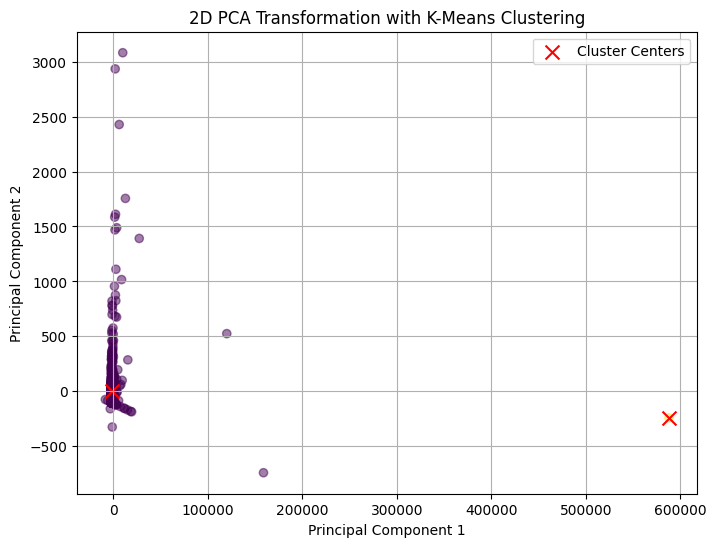

not outliers


(19, 27)

outliers


(131, 27)

,False,True
CASH_TA,0.340000,0.660000
SAL_TA,0.653333,0.346667
CF_CL,0.680000,0.320000
CF_TL,0.680000,0.320000
L2,0.706667,0.293333
L3,0.800000,0.200000
CF_SAL,0.833333,0.166667
EQ_TL,0.840000,0.160000
ROE,0.880000,0.120000
L1,0.880000,0.120000


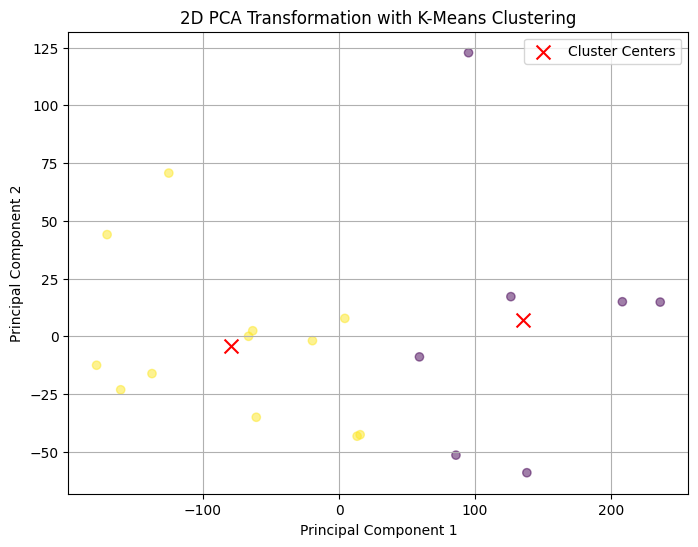

not outliers


(4485, 27)

outliers


(11110, 27)

,False,True
CASH_TA,0.298172,0.701828
ROE,0.990253,0.009747
L3,0.991151,0.008849
ROS,0.991600,0.008400
L2,0.991728,0.008272
CF_SAL,0.991728,0.008272
EAT_YIE,0.992113,0.007887
CF_CL,0.992754,0.007246
L1,0.993203,0.006797
EQ_TL,0.993203,0.006797


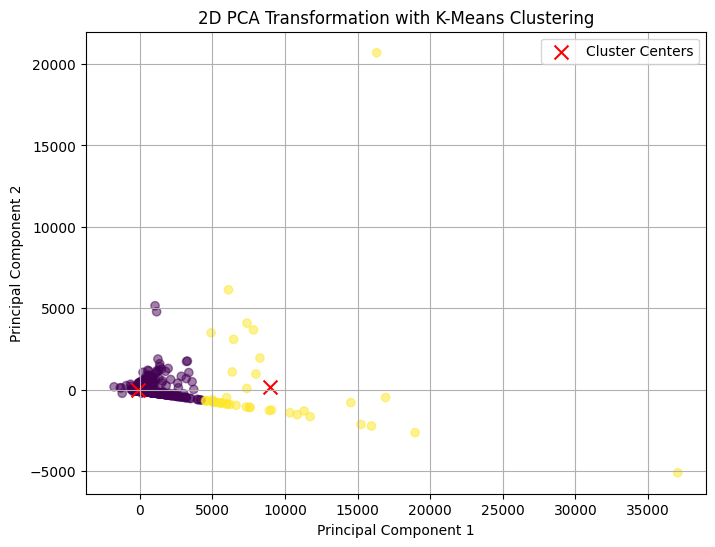

not outliers


(47, 27)

outliers


(475, 27)

,False,True
NCL_TA,0.314176,0.685824
CASH_TA,0.417625,0.582375
TL_TA,0.770115,0.229885
EQ_TA,0.781609,0.218391
ROA_BRUTTO,0.831418,0.168582
ROA_NETTO,0.839080,0.160920
EAT_TA,0.839080,0.160920
CF_TA,0.840996,0.159004
ROI,0.844828,0.155172
CF_CL,0.896552,0.103448


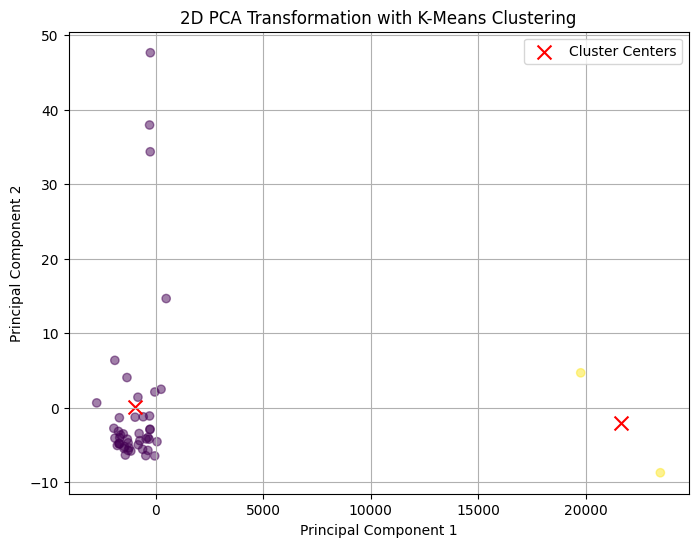

not outliers


(268, 27)

outliers


(564, 27)

,False,True
CASH_TA,0.401442,0.598558
CF_TL,0.913462,0.086538
INV_SAL,0.933894,0.066106
L1,0.948317,0.051683
EQ_TL,0.951923,0.048077
ROE,0.977163,0.022837
CF_CL,0.979567,0.020433
TA_SAL,0.981971,0.018029
CL_CC,0.983173,0.016827
CC_SAL,0.985577,0.014423


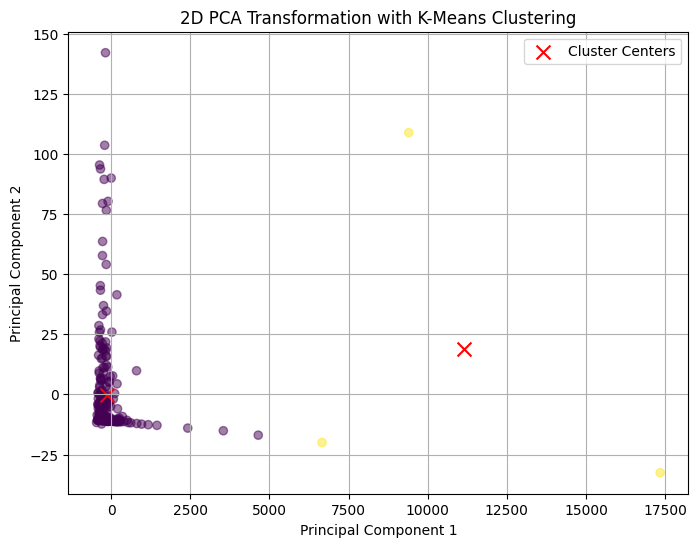

In [15]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


year = 2017
# sknace = 'C'

for sknace in ['A', 'B', 'C', 'D', 'E']:

    subset = financial_ratios_table.query('year == @year and sknace_division == @sknace and period_length == 12 and SAL != 0')[FINANCIAL_RATIOS]


    outliers = subset.apply(get_outliers)

    print('not outliers')
    display(subset[~outliers.apply(lambda x:any(x), axis=1)].shape)

    print('outliers')
    display(subset[outliers.apply(lambda x:any(x), axis=1)].shape)

    display(outliers.apply(lambda x: x.value_counts(normalize=True)).T.sort_values(True, ascending = False))

    subset = subset[~outliers.apply(lambda x:any(x), axis=1)]    
    
    for col in subset.columns:

        mean_filler = subset[col].mean()
        subset[col] = subset[col].fillna(mean_filler)
        

    # pca = PCA(n_components=2)  # Choosing 2 components for 2D visualization
    # transformed_data = pca.fit_transform(subset)

    # # Plot the transformed data as a scatterplot
    # plt.figure(figsize=(8, 6))
    # plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.5)
    # plt.title('2D PCA Transformation')
    # plt.xlabel('Principal Component 1')
    # plt.ylabel('Principal Component 2')
    # plt.grid(True)
    # plt.show()


    pca = PCA(n_components=2)  # Choosing 2 components for 2D visualization
    transformed_data = pca.fit_transform(subset)

    # Apply k-means clustering
    kmeans = KMeans(n_clusters=2)  # Choosing number of clusters
    kmeans.fit(transformed_data)
    clusters = kmeans.predict(transformed_data)



    # Plot the transformed data as a scatterplot
    plt.figure(figsize=(8, 6))
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=clusters, cmap='viridis', alpha=0.5)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=100, c='red', label='Cluster Centers')
    plt.title('2D PCA Transformation with K-Means Clustering')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()


    # plt.figure(figsize=(8, 6))
    # plt.hist(subset['EBIT_INT'])
    # plt.grid(True)
    # plt.show()


    # subset['cluster'] = clusters

    # C1 = subset.query('cluster == 0')
    # C2 = subset.query('cluster == 1')

    # for col in C1.columns:
        
    #     plt.scatter(C1[col], C1['cluster'])
    #     plt.scatter(C2[col], C2['cluster'])
    #     plt.title(col)
    #     plt.show()


In [16]:
data = subset['EAT_YIE']
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

display(Q1, Q3)
display(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
display(data.sort_values().head(20))
display(data.sort_values(ascending = False).head(20))

-0.001577955669333675

0.07628331708358152

-0.11836986479870647

0.1930752262129543

1289701   -11.804035
191412     -2.760552
1276013    -2.545251
1386432    -2.170332
196326     -1.183844
1284956    -1.011219
431577     -0.562338
276471     -0.538260
1257582    -0.527824
1291358    -0.522957
676876     -0.455004
846629     -0.409174
1280074    -0.398562
2008683    -0.356394
576175     -0.349550
314506     -0.342927
411872     -0.298848
64658      -0.229859
526910     -0.204824
41134      -0.192688
Name: EAT_YIE, dtype: float64

1199147    0.493074
1218337    0.372683
274005     0.352843
16405      0.342141
579389     0.302174
426556     0.294604
669516     0.290055
1956691    0.271313
2035901    0.268882
381196     0.257284
234586     0.255492
394486     0.249277
2044403    0.236732
1025689    0.232014
115340     0.212780
821977     0.203578
987133     0.201709
2055947    0.200831
429330     0.198586
1950099    0.186829
Name: EAT_YIE, dtype: float64

In [25]:
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(nrows=int(len(SKNACE) / 3) + 1, ncols=3, figsize=(20, 30))
# axes = axes.flatten()

# for i, sknace_division in enumerate(SKNACE):
#     ax = axes[i]

#     data = merged_df.query('sknace_division == @sknace_division and year == 2018 and SAL != 0')['SAL']
    
#     Q1 = data.quantile(0.25)
#     Q3 = data.quantile(0.75)
    
#     IQR = Q3 - Q1
    
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     cleaned_data = data[~((data < lower_bound) | (data > upper_bound))]

#     bin_width = 2 * IQR / (len(cleaned_data) ** (1/3))

#     num_bins = int(np.ceil((np.max(cleaned_data) - np.min(cleaned_data)) / bin_width))

#     ax.hist(cleaned_data, bins=num_bins, color='skyblue', edgecolor='black')
#     ax.set_title(sknace_division)
#     ax.set_xlabel('Value')
#     ax.set_ylabel('Frequency')

# plt.tight_layout()
# plt.show()

NameError: name 'SKNACE' is not defined